In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score

# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-07-18 14:53:02.893450: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-18 14:53:02.918963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 14:53:03.357441: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def data_imdb():
    dataset = load_dataset("imdb")
    train_data = dataset['train']
    test_data = dataset['test']

    df_train = train_data.to_pandas()  # Convert the training dataset to a Pandas DataFrame
    df_test = test_data.to_pandas()  # Convert the validation dataset to a Pandas DataFrame

    df_train['sentiment'] = df_train['label'].map({0: 'bad', 1: 'good'})
    df_test['sentiment'] = df_test['label'].map({0: 'bad', 1: 'good'})

    possible_labels = df_train.sentiment.unique()  # Get unique category labels from the training DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df_train['label'] = df_train.sentiment.replace(label_dict)
    df_test['label'] = df_test.sentiment.replace(label_dict)

    df_train['data_type'] = 'train'  # Set the 'data_type' column to 'train' for training data
    df_test['data_type'] = 'test'  # Set the 'data_type' column to 'val' for validation data

    df = pd.concat([df_train, df_test], ignore_index=True)  # Merge the training and validation dataframes

    return df


def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels, label_dict):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Initialize the confusion matrix.
    num_classes = len(label_dict)
    confusion_mat = confusion_matrix(labels_flat, preds_flat, labels=list(range(num_classes)))
    
    # Calculate accuracy and F1 score per class
    accuracies = {}
    f1_scores = {}
    for label in range(num_classes):
        # Calculate accuracy for this class
        num_correct = confusion_mat[label, label]
        num_instances = np.sum(confusion_mat[label, :])
        accuracy = num_correct / num_instances * 100
        accuracies[label] = accuracy
        
        # Calculate F1 score for this class
        f1 = f1_score(labels_flat, preds_flat, labels=[label], average='weighted')
        f1_scores[label] = f1

        # Print the class name, accuracy numerator, and denominator.
        class_name = label_dict_inverse[label]
        print(f'Class: {class_name}')
        print(f'Accuracy: {num_correct}/{num_instances} ({accuracy:.2f}%)')
        print(f'F1 Score: {f1:.2f}\n')

    # Calculate total accuracy and F1 score
    total_accuracy = accuracy_score(labels_flat, preds_flat) * 100
    total_f1_score = f1_score(labels_flat, preds_flat, average='weighted')

    # Print the total accuracy and F1 score
    print(f'Total Accuracy: {total_accuracy:.2f}%')
    print(f'Total F1 Score: {total_f1_score:.2f}')


#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_gpt_bert_imdb_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

    return training_loss_list, validation_loss_list, accuracy_list, precision_list, f1_score_list

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = data_imdb()

Found cached dataset imdb (/home/z123010/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,text,label,sentiment,data_type
33553,Forget what I said about Emeril. Rachael Ray i...,0,bad,test
9427,Former private eye-turned-security guard ditch...,0,bad,train
199,Mann photographs the Alberta Rocky Mountains i...,0,bad,train
12447,Simply put: the movie is boring. Cliché upon c...,0,bad,train
39489,"Now being a fan of sci fi, the trailer for thi...",1,good,test
42724,"In 'Hoot' Logan Lerman plays Roy Eberhardt, th...",1,good,test
10822,This is the worst film I have ever seen.I was ...,0,bad,train
49498,I think that Toy Soldiers is an excellent movi...,1,good,test
4144,I think Micheal Ironsides acting career must b...,0,bad,train
36958,This was a disgrace to the game FarCry i had m...,0,bad,test


In [6]:
df.groupby(['sentiment']).count()

,text,label,data_type
sentiment,,,
bad,25000,25000,25000
good,25000,25000,25000


In [7]:
df.groupby(['data_type']).count()

,text,label,sentiment
data_type,,,
test,25000,25000,25000
train,25000,25000,25000


In [8]:
# Load BERT tokenizer
pretrained_path = 'bert-base-uncased'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_text = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids_train = encoded_data_train_text['input_ids']
attention_masks_train = encoded_data_train_text['attention_mask']

labels_train = torch.tensor(df[df.data_type=='train'].label.values)

encoded_data_test_text = tokenizer.batch_encode_plus(
    df[df.data_type=='test'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

input_ids_test = encoded_data_test_text['input_ids']
attention_masks_test = encoded_data_test_text['attention_mask']

labels_test = torch.tensor(df[df.data_type=='test'].label.values)

In [9]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
len(dataset_train), len(dataset_test)

(25000, 25000)

In [10]:
import torch
import torch.nn as nn
from transformers import BertModel, BertConfig, GPT2Model, GPT2Config

num_classes = 2

class SentimentModel(nn.Module):
    def __init__(self, pretrained_bert_path, pretrained_gpt_path):
        super(SentimentModel, self).__init__()

        gpt_config = GPT2Config(
            vocab_size=50257,
            hidden_size=128,  # Reduce hidden size
            num_hidden_layers=4,  # Reduce number of layers
            num_attention_heads=4,  # Reduce number of attention heads
            intermediate_size=256,  # Reduce intermediate size
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.3,
        )
        self.gpt = GPT2Model(config=gpt_config)
        self.gpt_ln = nn.LayerNorm(gpt_config.hidden_size)
        
        bert_config = BertConfig(
            vocab_size=50257,
            hidden_size=128,  # Reduce hidden size
            num_hidden_layers=4,  # Reduce number of layers
            num_attention_heads=4,  # Reduce number of attention heads
            intermediate_size=256,  # Reduce intermediate size
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.3,
        )
        self.bert = BertModel(config=bert_config)
        self.bert_ln = nn.LayerNorm(bert_config.hidden_size)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(bert_config.hidden_size + gpt_config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        gpt_outputs = self.gpt_ln(gpt_outputs) + gpt_outputs  # Residual connection
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)[0]
        bert_outputs = self.bert_ln(bert_outputs) + bert_outputs  # Residual connection
        
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        bert_pooled_output = self.dropout(bert_outputs[:, 0, :])  # Use the [CLS] token representation
        
        combined_outputs = torch.cat((gpt_last_hidden_state, bert_pooled_output), dim=1)
        
        logits = self.fc(combined_outputs)
        outputs = nn.functional.softmax(logits, dim=1)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs


In [11]:
# Create model instance
model = SentimentModel('bert-base-uncased', 'gpt2')

In [12]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (gpt): GPT2Model(
    (wte): Embedding(50257, 128)
    (wpe): Embedding(1024, 128)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPT2Block(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (gpt_ln): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50257, 128, padding_idx=0)
      (posi

In [13]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [14]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 32 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=batch_size
)

In [15]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Define the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8,
    weight_decay=0.0001

)


epochs = 50
patience = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [16]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [18]:
trainer = Trainer(
model=model,
args=training_args,
train_dataset=dataset_train,
eval_dataset=dataset_train,
)


Fold 1


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7137028214691038
Validation loss: 0.5360085119175005
F1 Score (weighted): 0.7276563484880446


Epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5092079385649413
Validation loss: 0.4243426405930821
F1 Score (weighted): 0.8067428940944749
28.65% Training loss decreased compared to the previous epoch
20.83% Validation loss decreased compared to the previous epoch
10.87% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.40342627358834515
Validation loss: 0.3964988350679603
F1 Score (weighted): 0.8319225784648313
20.77% Training loss decreased compared to the previous epoch
6.56% Validation loss decreased compared to the previous epoch
3.12% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.3393393935191191
Validation loss: 0.3934535133310511
F1 Score (weighted): 0.8444626517076784
15.89% Training loss decreased compared to the previous epoch
0.77% Validation loss decreased compared to the previous epoch
1.51% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.29683931035370653
Validation loss: 0.34570423853171023
F1 Score (weighted): 0.8620100464401858
12.52% Training loss decreased compared to the previous epoch
12.14% Validation loss decreased compared to the previous epoch
2.08% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.26952906194492243
Validation loss: 0.34089269036356407
F1 Score (weighted): 0.8664369411324948
9.2% Training loss decreased compared to the previous epoch
1.39% Validation loss decreased compared to the previous epoch
0.51% F1 Score increased compared to the previous epoch


Epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.24333221875448627
Validation loss: 0.335176944072488
F1 Score (weighted): 0.8667979327356694
9.72% Training loss decreased compared to the previous epoch
1.68% Validation loss decreased compared to the previous epoch
0.04% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.22911084750243885
Validation loss: 0.3096893700547045
F1 Score (weighted): 0.873645324502022
5.84% Training loss decreased compared to the previous epoch
7.6% Validation loss decreased compared to the previous epoch
0.79% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.2020283063333905
Validation loss: 0.3228635823802103
F1 Score (weighted): 0.8756401127277331
11.82% Training loss decreased compared to the previous epoch
4.25% Validation loss increased compared to the previous epoch
0.23% F1 Score increased compared to the previous epoch


Epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.1905549527794144
Validation loss: 0.32873764825112456
F1 Score (weighted): 0.8760228008500665
5.68% Training loss decreased compared to the previous epoch
1.82% Validation loss increased compared to the previous epoch
0.04% F1 Score increased compared to the previous epoch


Epoch 11:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.17658148746836974
Validation loss: 0.3734237014808209
F1 Score (weighted): 0.8816
7.33% Training loss decreased compared to the previous epoch
13.59% Validation loss increased compared to the previous epoch
0.64% F1 Score increased compared to the previous epoch


Epoch 12:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.16231307850235185
Validation loss: 0.37098136233000817
F1 Score (weighted): 0.8771980941436952
8.08% Training loss decreased compared to the previous epoch
0.65% Validation loss decreased compared to the previous epoch
0.5% F1 Score decreased compared to the previous epoch


Epoch 13:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.1512609236114341
Validation loss: 0.39145344943751265
F1 Score (weighted): 0.8780262165722543
6.81% Training loss decreased compared to the previous epoch
5.52% Validation loss increased compared to the previous epoch
0.09% F1 Score increased compared to the previous epoch


Epoch 14:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.1434564857534662
Validation loss: 0.38174403131691903
F1 Score (weighted): 0.8751245100894528
5.16% Training loss decreased compared to the previous epoch
2.48% Validation loss decreased compared to the previous epoch
0.33% F1 Score decreased compared to the previous epoch


Epoch 15:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.13594150780872125
Validation loss: 0.3634839416776277
F1 Score (weighted): 0.880031285010675
5.24% Training loss decreased compared to the previous epoch
4.78% Validation loss decreased compared to the previous epoch
0.56% F1 Score increased compared to the previous epoch


Epoch 16:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.12266170027181612
Validation loss: 0.46085810156751283
F1 Score (weighted): 0.8647438389788904
9.77% Training loss decreased compared to the previous epoch
26.79% Validation loss increased compared to the previous epoch
1.74% F1 Score decreased compared to the previous epoch


Epoch 17:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.12059982859235871
Validation loss: 0.44388683235178455
F1 Score (weighted): 0.8792314935774128
1.68% Training loss decreased compared to the previous epoch
3.68% Validation loss decreased compared to the previous epoch
1.68% F1 Score increased compared to the previous epoch


Epoch 18:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.11546824488786198
Validation loss: 0.4276369683373767
F1 Score (weighted): 0.8823613091157229
4.26% Training loss decreased compared to the previous epoch
3.66% Validation loss decreased compared to the previous epoch
0.36% F1 Score increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 36.416588048140206 minutes
Final Accuracy: 0.8824
Final Precision: 0.8824143062515403


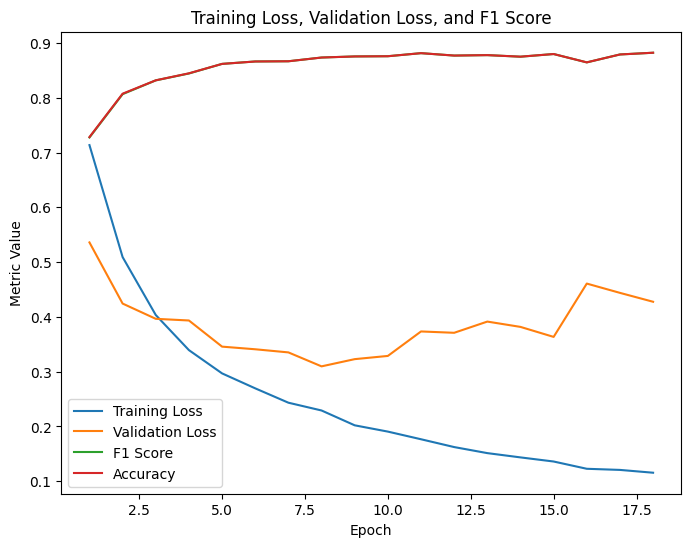

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.7137028214691038   0.5360085119175005   0.7276563484880446  0.7284                 0.728857
2                     0.5092079385649413   0.4243426405930821   0.8067428940944749  0.8067428940944749     0.806743
3                     0.40342627358834515  0.3964988350679603   0.8319225784648313  0.8319225784648313     0.831923
4                     0.3393393935191191   0.3934535133310511   0.8444626517076784  0.8444626517076784     0.844463
5                     0.29683931035370653  0.34570423853171023  0.8620100464401858  0.8620100464401858     0.86201
6                     0.26952906194492243  0.34089269036356407  0.8664369411324948  0.8664369411324948     0.866437
7                     0.24333221875448627  0.335176944072488    0.8667979

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.1371949375600459
Validation loss: 0.07470039831167913
F1 Score (weighted): 0.9743775399855443


Epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.1327713830378343
Validation loss: 0.06788630214080663
F1 Score (weighted): 0.9760021514795264
3.22% Training loss decreased compared to the previous epoch
9.12% Validation loss decreased compared to the previous epoch
0.17% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.12104697320451537
Validation loss: 0.06788412827550422
F1 Score (weighted): 0.9783973710103928
8.83% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch
0.25% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.12150706747359602
Validation loss: 0.07550595870795601
F1 Score (weighted): 0.9751947883771278
0.38% Training loss increased compared to the previous epoch
11.23% Validation loss increased compared to the previous epoch
0.33% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.11436834250608544
Validation loss: 0.07935910423498459
F1 Score (weighted): 0.97599947737334
5.88% Training loss decreased compared to the previous epoch
5.1% Validation loss increased compared to the previous epoch
0.08% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.10896898667289695
Validation loss: 0.0866229377548458
F1 Score (weighted): 0.9756023630637228
4.72% Training loss decreased compared to the previous epoch
9.15% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.10566865215498017
Validation loss: 0.10157341879491895
F1 Score (weighted): 0.9684053252639562
3.03% Training loss decreased compared to the previous epoch
17.26% Validation loss increased compared to the previous epoch
0.74% F1 Score decreased compared to the previous epoch


Epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.10272991892138221
Validation loss: 0.0975677947605123
F1 Score (weighted): 0.9747950959719474
2.78% Training loss decreased compared to the previous epoch
3.94% Validation loss decreased compared to the previous epoch
0.66% F1 Score increased compared to the previous epoch


Epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.09748175077592433
Validation loss: 0.11789785722960258
F1 Score (weighted): 0.9716037866066628
5.11% Training loss decreased compared to the previous epoch
20.84% Validation loss increased compared to the previous epoch
0.33% F1 Score decreased compared to the previous epoch


Epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.09903418491723476
Validation loss: 0.13577903056505455
F1 Score (weighted): 0.9663631834916945
1.59% Training loss increased compared to the previous epoch
15.17% Validation loss increased compared to the previous epoch
0.54% F1 Score decreased compared to the previous epoch


Epoch 11:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.09091443110074496
Validation loss: 0.13247547787540487
F1 Score (weighted): 0.969193038919218
8.2% Training loss decreased compared to the previous epoch
2.43% Validation loss decreased compared to the previous epoch
0.29% F1 Score increased compared to the previous epoch


Epoch 12:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.0945188007407606
Validation loss: 0.13651029713366392
F1 Score (weighted): 0.971198708747658
3.96% Training loss increased compared to the previous epoch
3.05% Validation loss increased compared to the previous epoch
0.21% F1 Score increased compared to the previous epoch


Epoch 13:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.09253963727232159
Validation loss: 0.1364961981020361
F1 Score (weighted): 0.9676021421851114
2.09% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch
0.37% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 26.273953553040823 minutes
Final Accuracy: 0.9676
Final Precision: 0.9676194623722008


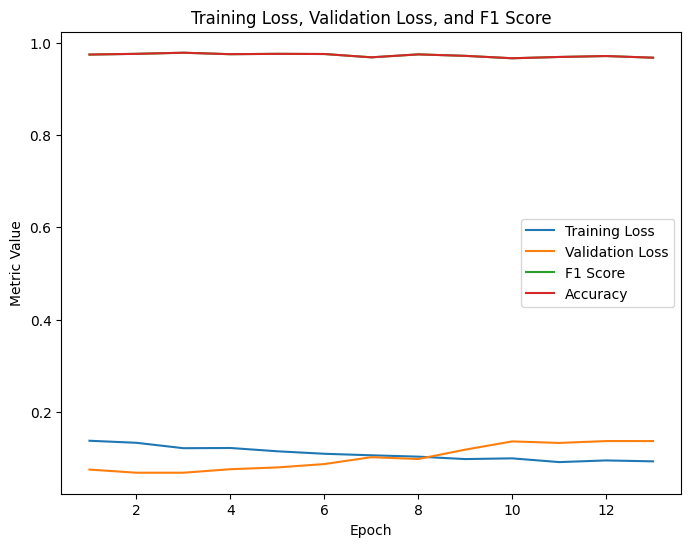

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.1371949375600459   0.07470039831167913  0.9743775399855443  0.9744                 0.975076
2                     0.1327713830378343   0.06788630214080663  0.9760021514795264  0.9760021514795264     0.976002
3                     0.12104697320451537  0.06788412827550422  0.9783973710103928  0.9783973710103928     0.978397
4                     0.12150706747359602  0.07550595870795601  0.9751947883771278  0.9751947883771278     0.975195
5                     0.11436834250608544  0.07935910423498459  0.97599947737334    0.97599947737334       0.975999
6                     0.10896898667289695  0.0866229377548458   0.9756023630637228  0.9756023630637228     0.975602
7                     0.10566865215498017  0.10157341879491895  0.968405

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.09725860639967075
Validation loss: 0.046731972947563455
F1 Score (weighted): 0.9892001192321717


Epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.09684439294729104
Validation loss: 0.03170078046342853
F1 Score (weighted): 0.9944000430119638
0.43% Training loss decreased compared to the previous epoch
32.16% Validation loss decreased compared to the previous epoch
0.53% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.09255869915903697
Validation loss: 0.033299801278051835
F1 Score (weighted): 0.9940001008071129
4.43% Training loss decreased compared to the previous epoch
5.04% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.09012296062709621
Validation loss: 0.03567701293217443
F1 Score (weighted): 0.9924001617373418
2.63% Training loss decreased compared to the previous epoch
7.14% Validation loss increased compared to the previous epoch
0.16% F1 Score decreased compared to the previous epoch


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.08228746420685308
Validation loss: 0.03763247691861153
F1 Score (weighted): 0.9924000304030404
8.69% Training loss decreased compared to the previous epoch
5.48% Validation loss increased compared to the previous epoch
0.0% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.08589504348715722
Validation loss: 0.037749253378450115
F1 Score (weighted): 0.9915999637077668
4.38% Training loss increased compared to the previous epoch
0.31% Validation loss increased compared to the previous epoch
0.08% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0782206059708518
Validation loss: 0.04058724494070357
F1 Score (weighted): 0.9924001860566033
8.93% Training loss decreased compared to the previous epoch
7.52% Validation loss increased compared to the previous epoch
0.08% F1 Score increased compared to the previous epoch


Epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.0769010629403717
Validation loss: 0.06807181449044095
F1 Score (weighted): 0.992000204808389
1.69% Training loss decreased compared to the previous epoch
67.72% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.07723776781180773
Validation loss: 0.05375964469733188
F1 Score (weighted): 0.9896001996811501
0.44% Training loss increased compared to the previous epoch
21.03% Validation loss decreased compared to the previous epoch
0.24% F1 Score decreased compared to the previous epoch


Epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.07502465867649087
Validation loss: 0.04480903695228427
F1 Score (weighted): 0.9916001787623254
2.87% Training loss decreased compared to the previous epoch
16.65% Validation loss decreased compared to the previous epoch
0.2% F1 Score increased compared to the previous epoch


Epoch 11:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.06852073746490946
Validation loss: 0.0520125805312632
F1 Score (weighted): 0.9900002704073119
8.67% Training loss decreased compared to the previous epoch
16.08% Validation loss increased compared to the previous epoch
0.16% F1 Score decreased compared to the previous epoch


Epoch 12:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.06631873707969631
Validation loss: 0.06821595185806185
F1 Score (weighted): 0.9867989289553507
3.21% Training loss decreased compared to the previous epoch
31.15% Validation loss increased compared to the previous epoch
0.32% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 24.245863234996797 minutes
Final Accuracy: 0.9868
Final Precision: 0.9868512467473928


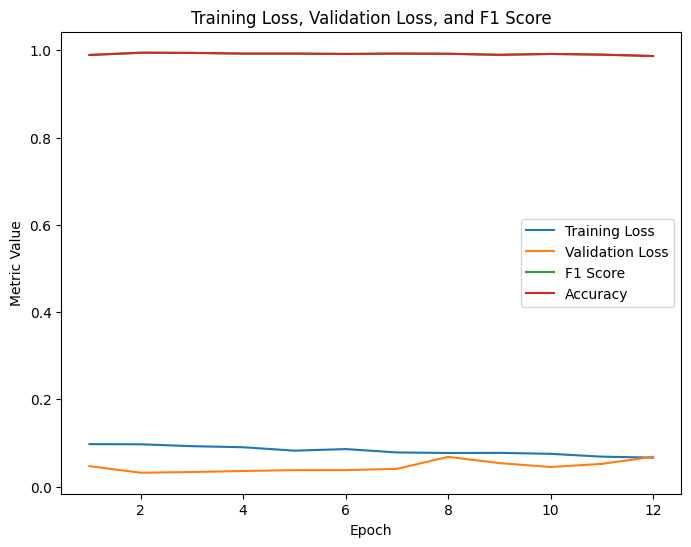

Epoch                 Training Loss        Validation Loss       F1 Score            Accuracy              Precision
--------------------  -------------------  --------------------  ------------------  ------------------  -----------
1                     0.09725860639967075  0.046731972947563455  0.9892001192321717  0.9892                 0.989368
2                     0.09684439294729104  0.03170078046342853   0.9944000430119638  0.9944000430119638     0.9944
3                     0.09255869915903697  0.033299801278051835  0.9940001008071129  0.9940001008071129     0.994
4                     0.09012296062709621  0.03567701293217443   0.9924001617373418  0.9924001617373418     0.9924
5                     0.08228746420685308  0.03763247691861153   0.9924000304030404  0.9924000304030404     0.9924
6                     0.08589504348715722  0.037749253378450115  0.9915999637077668  0.9915999637077668     0.9916
7                     0.0782206059708518   0.04058724494070357   0.99240018

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.07556771998600777
Validation loss: 0.016518287555184922
F1 Score (weighted): 0.9975999431181625


Epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.07484109830478371
Validation loss: 0.01613010273313539
F1 Score (weighted): 0.9975999431181625
0.96% Training loss decreased compared to the previous epoch
2.35% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.07123768717238735
Validation loss: 0.016125901591156528
F1 Score (weighted): 0.9975999431181625
4.81% Training loss decreased compared to the previous epoch
0.03% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.06976056005702379
Validation loss: 0.016769893710203824
F1 Score (weighted): 0.9975999431181625
2.07% Training loss decreased compared to the previous epoch
3.99% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.06521456662630953
Validation loss: 0.018676316495645863
F1 Score (weighted): 0.9971999672680915
6.52% Training loss decreased compared to the previous epoch
11.37% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.06716245092738146
Validation loss: 0.017624396660226645
F1 Score (weighted): 0.9971998991091983
2.99% Training loss increased compared to the previous epoch
5.63% Validation loss decreased compared to the previous epoch
0.0% F1 Score decreased compared to the previous epoch


Epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.06456551129204771
Validation loss: 0.01851588235158603
F1 Score (weighted): 0.9971998991091983
3.87% Training loss decreased compared to the previous epoch
5.06% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.06932246530604144
Validation loss: 0.01706572886279348
F1 Score (weighted): 0.9971998991091983
7.37% Training loss increased compared to the previous epoch
7.83% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.06861802060645707
Validation loss: 0.017840883292293153
F1 Score (weighted): 0.9971998991091983
1.02% Training loss decreased compared to the previous epoch
4.54% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.06123803880580619
Validation loss: 0.020391698466183595
F1 Score (weighted): 0.9968
10.76% Training loss decreased compared to the previous epoch
14.3% Validation loss increased compared to the previous epoch
0.04% F1 Score decreased compared to the previous epoch


Epoch 11:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.05848800054259713
Validation loss: 0.01832616556110892
F1 Score (weighted): 0.9971999672680915
4.49% Training loss decreased compared to the previous epoch
10.13% Validation loss decreased compared to the previous epoch
0.04% F1 Score increased compared to the previous epoch


Epoch 12:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.05788063703779368
Validation loss: 0.018438297155154045
F1 Score (weighted): 0.9971999672680915
1.04% Training loss decreased compared to the previous epoch
0.61% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.05809741257665089
Validation loss: 0.01850358999917826
F1 Score (weighted): 0.9971999672680915
0.37% Training loss increased compared to the previous epoch
0.35% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 26.26386103630066 minutes
Final Accuracy: 0.9972
Final Precision: 0.9972002539184732


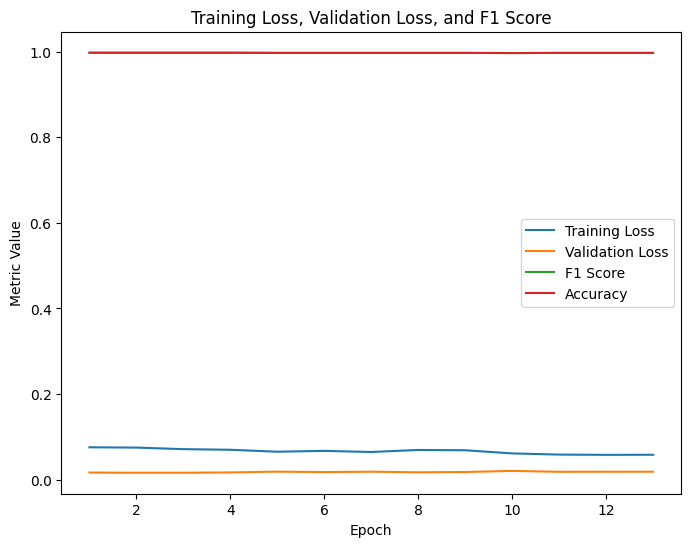

Epoch                 Training Loss        Validation Loss       F1 Score            Accuracy              Precision
--------------------  -------------------  --------------------  ------------------  ------------------  -----------
1                     0.07556771998600777  0.016518287555184922  0.9975999431181625  0.9976                 0.997601
2                     0.07484109830478371  0.01613010273313539   0.9975999431181625  0.9975999431181625     0.9976
3                     0.07123768717238735  0.016125901591156528  0.9975999431181625  0.9975999431181625     0.9976
4                     0.06976056005702379  0.016769893710203824  0.9975999431181625  0.9975999431181625     0.9976
5                     0.06521456662630953  0.018676316495645863  0.9971999672680915  0.9971999672680915     0.9972
6                     0.06716245092738146  0.017624396660226645  0.9971998991091983  0.9971998991091983     0.9972
7                     0.06456551129204771  0.01851588235158603   0.9971998

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.06457825045436039
Validation loss: 0.0014746374007803683
F1 Score (weighted): 0.9996000024966075


Epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.05981750219627264
Validation loss: 0.0014738990502325888
F1 Score (weighted): 0.9996000024966075
7.37% Training loss decreased compared to the previous epoch
0.05% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.05336974342278402
Validation loss: 0.00147389181664131
F1 Score (weighted): 0.9996000024966075
10.78% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.06564571612555235
Validation loss: 0.0014738438008471003
F1 Score (weighted): 0.9996000024966075
23.0% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.06033078543607024
Validation loss: 0.001475394159685113
F1 Score (weighted): 0.9996000024966075
8.1% Training loss decreased compared to the previous epoch
0.11% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.06161142508190923
Validation loss: 0.0014740847591959128
F1 Score (weighted): 0.9996000024966075
2.12% Training loss increased compared to the previous epoch
0.09% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.060258688554768014
Validation loss: 0.0014748429589244666
F1 Score (weighted): 0.9996000024966075
2.2% Training loss decreased compared to the previous epoch
0.05% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.06160129953253669
Validation loss: 0.0014731891437056415
F1 Score (weighted): 0.9996000024966075
2.23% Training loss increased compared to the previous epoch
0.11% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.06272998121291741
Validation loss: 0.001473073087208256
F1 Score (weighted): 0.9996000024966075
1.83% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.059443928749301864
Validation loss: 0.0014731902960699664
F1 Score (weighted): 0.9996000024966075
5.24% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.06121048712553933
Validation loss: 0.0014738402490745758
F1 Score (weighted): 0.9996000024966075
2.97% Training loss increased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 12:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.06429424874485531
Validation loss: 0.0014779976406282026
F1 Score (weighted): 0.9996000024966075
5.04% Training loss increased compared to the previous epoch
0.28% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.061104351938741856
Validation loss: 0.0014736970578603258
F1 Score (weighted): 0.9996000024966075
4.96% Training loss decreased compared to the previous epoch
0.29% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.057634952474018064
Validation loss: 0.0014736310599513258
F1 Score (weighted): 0.9996000024966075
5.68% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 15:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.06467714300304744
Validation loss: 0.0014740101973927003
F1 Score (weighted): 0.9996000024966075
12.22% Training loss increased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch


Epoch 16:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.059258345988258625
Validation loss: 0.001474207240271771
F1 Score (weighted): 0.9996000024966075
8.38% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 17:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.06664661059945005
Validation loss: 0.001473257479131151
F1 Score (weighted): 0.9996000024966075
12.47% Training loss increased compared to the previous epoch
0.06% Validation loss decreased compared to the previous epoch


Epoch 18:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.06186041687322524
Validation loss: 0.0014741874842969347
F1 Score (weighted): 0.9996000024966075
7.18% Training loss decreased compared to the previous epoch
0.06% Validation loss increased compared to the previous epoch


Epoch 19:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.06075816186731489
Validation loss: 0.00147468857526119
F1 Score (weighted): 0.9996000024966075
1.78% Training loss decreased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 38.384408338864645 minutes
Final Accuracy: 0.9996
Final Precision: 0.9996003249390738


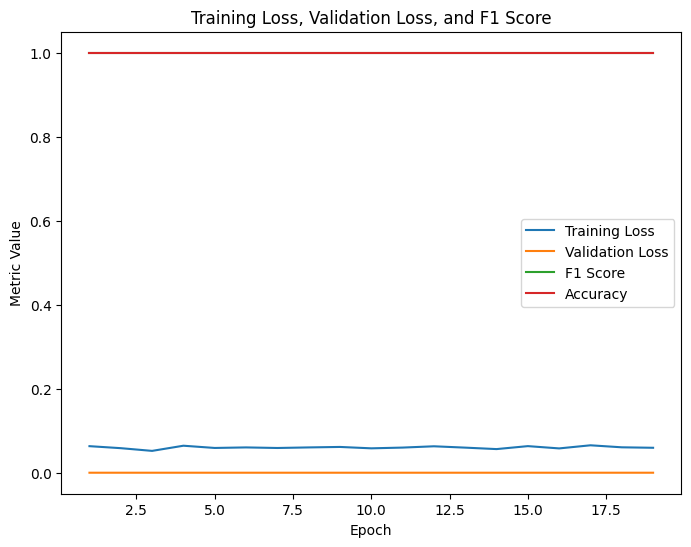

Epoch                 Training Loss         Validation Loss        F1 Score            Accuracy              Precision
--------------------  --------------------  ---------------------  ------------------  ------------------  -----------
1                     0.06457825045436039   0.0014746374007803683  0.9996000024966075  0.9996                   0.9996
2                     0.05981750219627264   0.0014738990502325888  0.9996000024966075  0.9996000024966075       0.9996
3                     0.05336974342278402   0.00147389181664131    0.9996000024966075  0.9996000024966075       0.9996
4                     0.06564571612555235   0.0014738438008471003  0.9996000024966075  0.9996000024966075       0.9996
5                     0.06033078543607024   0.001475394159685113   0.9996000024966075  0.9996000024966075       0.9996
6                     0.06161142508190923   0.0014740847591959128  0.9996000024966075  0.9996000024966075       0.9996
7                     0.060258688554768014  0.00

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.05638613667701975
Validation loss: 0.023343104437359055
F1 Score (weighted): 0.9964000316953405


Epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.05769872119336386
Validation loss: 0.02334493886689726
F1 Score (weighted): 0.9964000316953405
2.33% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.053994050521892364
Validation loss: 0.02334302842773238
F1 Score (weighted): 0.9964000316953405
6.42% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.05648446117079815
Validation loss: 0.02334258775742536
F1 Score (weighted): 0.9964000316953405
4.61% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.05233218111201991
Validation loss: 0.02334375973810041
F1 Score (weighted): 0.9964000316953405
7.35% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.060480898568130215
Validation loss: 0.023342129503615507
F1 Score (weighted): 0.9964000316953405
15.57% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.0596711820954955
Validation loss: 0.023343619157020826
F1 Score (weighted): 0.9964000316953405
1.34% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.06097719140449375
Validation loss: 0.023342849880890165
F1 Score (weighted): 0.9964000316953405
2.19% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.059258068248544245
Validation loss: 0.023342000583961867
F1 Score (weighted): 0.9964000316953405
2.82% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.05888835689450967
Validation loss: 0.023346148562820957
F1 Score (weighted): 0.9964000316953405
0.62% Training loss decreased compared to the previous epoch
0.02% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.06270696466154649
Validation loss: 0.023341763407268998
F1 Score (weighted): 0.9964000316953405
6.48% Training loss increased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.05792902532836954
Validation loss: 0.023343389913884783
F1 Score (weighted): 0.9964000316953405
7.62% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.06334623166081986
Validation loss: 0.023343043907654553
F1 Score (weighted): 0.9964000316953405
9.35% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.059947251213006064
Validation loss: 0.023341793194855267
F1 Score (weighted): 0.9964000316953405
5.37% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 15:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.059737566126800215
Validation loss: 0.023340746495855054
F1 Score (weighted): 0.9964000316953405
0.35% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 16:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.058593740094858564
Validation loss: 0.023342840425092493
F1 Score (weighted): 0.9964000316953405
1.91% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 17:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.06029768339555052
Validation loss: 0.023342550711933217
F1 Score (weighted): 0.9964000316953405
2.91% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 18:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.05742252119324059
Validation loss: 0.023343414738346953
F1 Score (weighted): 0.9964000316953405
4.77% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 19:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.061594463338017456
Validation loss: 0.023343859580817007
F1 Score (weighted): 0.9964000316953405
7.27% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 20:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.061164947151527566
Validation loss: 0.023340659074579613
F1 Score (weighted): 0.9964000316953405
0.7% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 21:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.055457732885439655
Validation loss: 0.023342387793111156
F1 Score (weighted): 0.9964000316953405
9.33% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 22:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.06158864490998894
Validation loss: 0.023341581405175827
F1 Score (weighted): 0.9964000316953405
11.06% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 23:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.05636658750385819
Validation loss: 0.023340921333985097
F1 Score (weighted): 0.9964000316953405
8.48% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 24:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.0629264465395119
Validation loss: 0.023345224557465082
F1 Score (weighted): 0.9964000316953405
11.64% Training loss increased compared to the previous epoch
0.02% Validation loss increased compared to the previous epoch


Epoch 25:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.06086690471945324
Validation loss: 0.023344361428112453
F1 Score (weighted): 0.9964000316953405
3.27% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 26:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.05996358807095186
Validation loss: 0.02334874302857626
F1 Score (weighted): 0.9964000316953405
1.48% Training loss decreased compared to the previous epoch
0.02% Validation loss increased compared to the previous epoch


Epoch 27:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.0519395755864025
Validation loss: 0.02334081096673396
F1 Score (weighted): 0.9964000316953405
13.38% Training loss decreased compared to the previous epoch
0.03% Validation loss decreased compared to the previous epoch


Epoch 28:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.05847655617605018
Validation loss: 0.023341446789276278
F1 Score (weighted): 0.9964000316953405
12.59% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 29:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.06026855485259313
Validation loss: 0.023341752457597495
F1 Score (weighted): 0.9964000316953405
3.06% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 30:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.05748513755290994
Validation loss: 0.023341550479961348
F1 Score (weighted): 0.9964000316953405
4.62% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 60.601489305496216 minutes
Final Accuracy: 0.9964
Final Precision: 0.9964003823864063


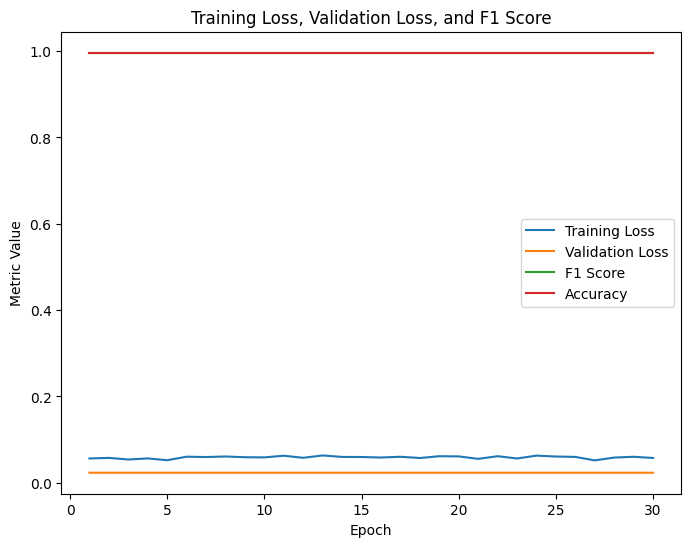

Epoch                 Training Loss         Validation Loss       F1 Score            Accuracy              Precision
--------------------  --------------------  --------------------  ------------------  ------------------  -----------
1                     0.05638613667701975   0.023343104437359055  0.9964000316953405  0.9964                   0.9964
2                     0.05769872119336386   0.02334493886689726   0.9964000316953405  0.9964000316953405       0.9964
3                     0.053994050521892364  0.02334302842773238   0.9964000316953405  0.9964000316953405       0.9964
4                     0.05648446117079815   0.02334258775742536   0.9964000316953405  0.9964000316953405       0.9964
5                     0.05233218111201991   0.02334375973810041   0.9964000316953405  0.9964000316953405       0.9964
6                     0.060480898568130215  0.023342129503615507  0.9964000316953405  0.9964000316953405       0.9964
7                     0.0596711820954955    0.0233436191

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.061066811165016006
Validation loss: 0.0062548144977639985
F1 Score (weighted): 0.9991999964158876


Epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0551277075982894
Validation loss: 0.006254461098792432
F1 Score (weighted): 0.9991999964158876
9.73% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.06030033782446315
Validation loss: 0.006254071509023492
F1 Score (weighted): 0.9991999964158876
9.38% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.06251952822516284
Validation loss: 0.006255180804468573
F1 Score (weighted): 0.9991999964158876
3.68% Training loss increased compared to the previous epoch
0.02% Validation loss increased compared to the previous epoch


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.058058900242485834
Validation loss: 0.0062550822003225835
F1 Score (weighted): 0.9991999964158876
7.13% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.06191365936390205
Validation loss: 0.006255743486506133
F1 Score (weighted): 0.9991999964158876
6.64% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.059364656986417685
Validation loss: 0.006255440968766667
F1 Score (weighted): 0.9991999964158876
4.12% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.05656339802862931
Validation loss: 0.006255518991346884
F1 Score (weighted): 0.9991999964158876
4.72% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.06116915850535323
Validation loss: 0.006254271623646086
F1 Score (weighted): 0.9991999964158876
8.14% Training loss increased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.05853876505551108
Validation loss: 0.006253231259149829
F1 Score (weighted): 0.9991999964158876
4.3% Training loss decreased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 11:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.06278628966038013
Validation loss: 0.006254910430620436
F1 Score (weighted): 0.9991999964158876
7.26% Training loss increased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch


Epoch 12:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.05925513501948775
Validation loss: 0.006254516723580493
F1 Score (weighted): 0.9991999964158876
5.62% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.06299476140768755
Validation loss: 0.006255575507301601
F1 Score (weighted): 0.9991999964158876
6.31% Training loss increased compared to the previous epoch
0.02% Validation loss increased compared to the previous epoch


Epoch 14:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.06116129599827631
Validation loss: 0.006254447887863822
F1 Score (weighted): 0.9991999964158876
2.91% Training loss decreased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 15:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.06060561627117005
Validation loss: 0.006256980396721725
F1 Score (weighted): 0.9991999964158876
0.91% Training loss decreased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 16:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.06440066753521023
Validation loss: 0.0062555675755867944
F1 Score (weighted): 0.9991999964158876
6.26% Training loss increased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 17:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.0628157713132499
Validation loss: 0.0062555873492449714
F1 Score (weighted): 0.9991999964158876
2.46% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 18:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.06043421442539263
Validation loss: 0.00625520780177115
F1 Score (weighted): 0.9991999964158876
3.79% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 19:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.06003372758343837
Validation loss: 0.006255030765012496
F1 Score (weighted): 0.9991999964158876
0.66% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 20:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.05922231696678699
Validation loss: 0.006254119119942896
F1 Score (weighted): 0.9991999964158876
1.35% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 40.455784459908806 minutes
Final Accuracy: 0.9992
Final Precision: 0.9992012718600954


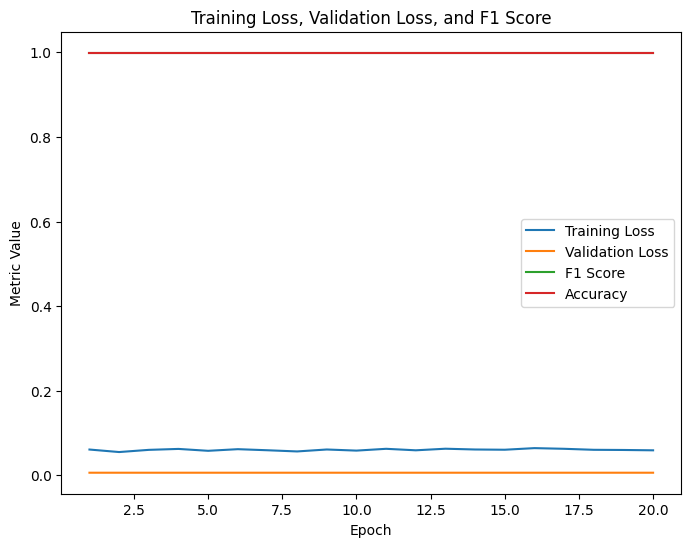

Epoch                 Training Loss         Validation Loss        F1 Score            Accuracy              Precision
--------------------  --------------------  ---------------------  ------------------  ------------------  -----------
1                     0.061066811165016006  0.0062548144977639985  0.9991999964158876  0.9992                 0.999201
2                     0.0551277075982894    0.006254461098792432   0.9991999964158876  0.9991999964158876     0.9992
3                     0.06030033782446315   0.006254071509023492   0.9991999964158876  0.9991999964158876     0.9992
4                     0.06251952822516284   0.006255180804468573   0.9991999964158876  0.9991999964158876     0.9992
5                     0.058058900242485834  0.0062550822003225835  0.9991999964158876  0.9991999964158876     0.9992
6                     0.06191365936390205   0.006255743486506133   0.9991999964158876  0.9991999964158876     0.9992
7                     0.059364656986417685  0.006255440968

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.06191514468074191
Validation loss: 0.014323538195052998
F1 Score (weighted): 0.9979999983999936


Epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.06328548218041098
Validation loss: 0.014325888644346873
F1 Score (weighted): 0.9979999983999936
2.21% Training loss increased compared to the previous epoch
0.02% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.061062599030058416
Validation loss: 0.014323561712790022
F1 Score (weighted): 0.9979999983999936
3.51% Training loss decreased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.06465377097000866
Validation loss: 0.014322208328308137
F1 Score (weighted): 0.9979999983999936
5.88% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.05662852617660974
Validation loss: 0.014324714113955233
F1 Score (weighted): 0.9979999983999936
12.41% Training loss decreased compared to the previous epoch
0.02% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.06580525235713966
Validation loss: 0.014324210201393035
F1 Score (weighted): 0.9979999983999936
16.21% Training loss increased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.06400942375611604
Validation loss: 0.014322728970415206
F1 Score (weighted): 0.9979999983999936
2.73% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.05951164732831868
Validation loss: 0.014323060898127954
F1 Score (weighted): 0.9979999983999936
7.03% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.06528223499381883
Validation loss: 0.014323886841995336
F1 Score (weighted): 0.9979999983999936
9.7% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.06140201797866625
Validation loss: 0.014325725291546175
F1 Score (weighted): 0.9979999983999936
5.94% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.06661705772595186
Validation loss: 0.014324695353405078
F1 Score (weighted): 0.9979999983999936
8.49% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.05395234613520601
Validation loss: 0.014325093032565274
F1 Score (weighted): 0.9979999983999936
19.01% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.06399502983876201
Validation loss: 0.014322841363882387
F1 Score (weighted): 0.9979999983999936
18.61% Training loss increased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.058612081686739904
Validation loss: 0.014323939901962287
F1 Score (weighted): 0.9979999983999936
8.41% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 28.33484891653061 minutes
Final Accuracy: 0.998
Final Precision: 0.9980003161618212


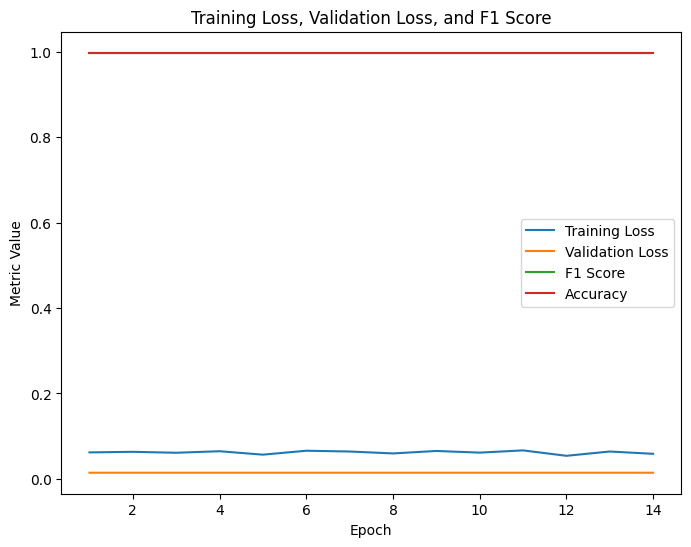

Epoch                 Training Loss         Validation Loss       F1 Score            Accuracy              Precision
--------------------  --------------------  --------------------  ------------------  ------------------  -----------
1                     0.06191514468074191   0.014323538195052998  0.9979999983999936  0.998                    0.998
2                     0.06328548218041098   0.014325888644346873  0.9979999983999936  0.9979999983999936       0.998
3                     0.061062599030058416  0.014323561712790022  0.9979999983999936  0.9979999983999936       0.998
4                     0.06465377097000866   0.014322208328308137  0.9979999983999936  0.9979999983999936       0.998
5                     0.05662852617660974   0.014324714113955233  0.9979999983999936  0.9979999983999936       0.998
6                     0.06580525235713966   0.014324210201393035  0.9979999983999936  0.9979999983999936       0.998
7                     0.06400942375611604   0.0143227289704152

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.06631869244583041
Validation loss: 0.006677602857640131
F1 Score (weighted): 0.9988000132580995


Epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.06349185883275575
Validation loss: 0.006681868097674149
F1 Score (weighted): 0.9988000132580995
4.26% Training loss decreased compared to the previous epoch
0.06% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.05782666738605258
Validation loss: 0.006675946842687488
F1 Score (weighted): 0.9988000132580995
8.92% Training loss decreased compared to the previous epoch
0.09% Validation loss decreased compared to the previous epoch


Epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.05903648101155506
Validation loss: 0.006674822643133988
F1 Score (weighted): 0.9988000132580995
2.09% Training loss increased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.06772660151554274
Validation loss: 0.006675644772557565
F1 Score (weighted): 0.9988000132580995
14.72% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.0588479994023394
Validation loss: 0.006677331624676391
F1 Score (weighted): 0.9988000132580995
13.11% Training loss decreased compared to the previous epoch
0.03% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.05846748811952487
Validation loss: 0.006677492015149232
F1 Score (weighted): 0.9988000132580995
0.65% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.063144782782398
Validation loss: 0.0066767969268928225
F1 Score (weighted): 0.9988000132580995
8.0% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.06350788668375819
Validation loss: 0.006675892604936409
F1 Score (weighted): 0.9988000132580995
0.58% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.06694508350268404
Validation loss: 0.006681062904101078
F1 Score (weighted): 0.9988000132580995
5.41% Training loss increased compared to the previous epoch
0.08% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.058530129440193625
Validation loss: 0.02731746471637294
F1 Score (weighted): 0.9988000132580995
12.57% Training loss decreased compared to the previous epoch
308.88% Validation loss increased compared to the previous epoch


Epoch 12:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.05844045064350212
Validation loss: 0.006678801785146558
F1 Score (weighted): 0.9988000132580995
0.15% Training loss decreased compared to the previous epoch
75.55% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.06145596178475898
Validation loss: 0.006675443064960757
F1 Score (weighted): 0.9988000132580995
5.16% Training loss increased compared to the previous epoch
0.05% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.06001276359980197
Validation loss: 0.006675069726181299
F1 Score (weighted): 0.9988000132580995
2.35% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 28.347691758473715 minutes
Final Accuracy: 0.9988
Final Precision: 0.9988003463682571


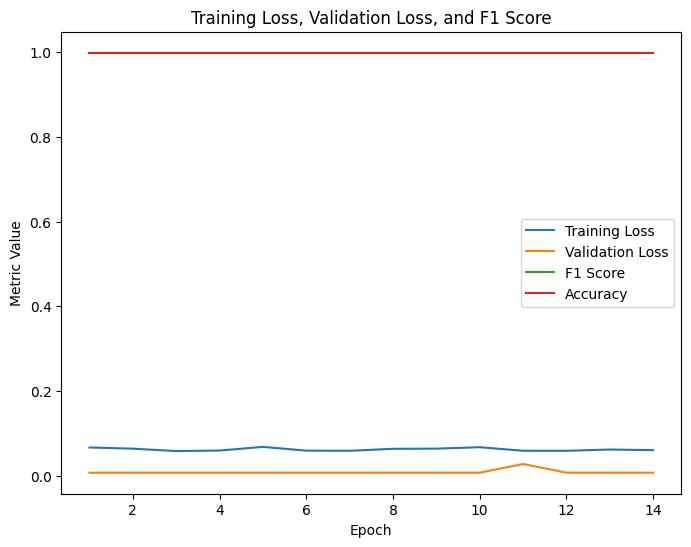

Epoch                 Training Loss         Validation Loss        F1 Score            Accuracy              Precision
--------------------  --------------------  ---------------------  ------------------  ------------------  -----------
1                     0.06631869244583041   0.006677602857640131   0.9988000132580995  0.9988                   0.9988
2                     0.06349185883275575   0.006681868097674149   0.9988000132580995  0.9988000132580995       0.9988
3                     0.05782666738605258   0.006675946842687488   0.9988000132580995  0.9988000132580995       0.9988
4                     0.05903648101155506   0.006674822643133988   0.9988000132580995  0.9988000132580995       0.9988
5                     0.06772660151554274   0.006675644772557565   0.9988000132580995  0.9988000132580995       0.9988
6                     0.0588479994023394    0.006677331624676391   0.9988000132580995  0.9988000132580995       0.9988
7                     0.05846748811952487   0.00

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.05824083289107049
Validation loss: 0.007691061291460514
F1 Score (weighted): 0.9987999986559895


Epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.06510543366258306
Validation loss: 0.007690076470887878
F1 Score (weighted): 0.9987999986559895
11.79% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.06046910943624342
Validation loss: 0.007690462510357906
F1 Score (weighted): 0.9987999986559895
7.12% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.058707902427902976
Validation loss: 0.0076900000416502785
F1 Score (weighted): 0.9987999986559895
2.91% Training loss decreased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.06069559796403403
Validation loss: 0.0076892932790738255
F1 Score (weighted): 0.9987999986559895
3.39% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.06264035989306649
Validation loss: 0.007688707008934285
F1 Score (weighted): 0.9987999986559895
3.2% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.058986099340555403
Validation loss: 0.007689314548079443
F1 Score (weighted): 0.9987999986559895
5.83% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.05937407658778036
Validation loss: 0.007688318164076043
F1 Score (weighted): 0.9987999986559895
0.66% Training loss increased compared to the previous epoch
0.01% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.05940546815744793
Validation loss: 0.007689361149943257
F1 Score (weighted): 0.9987999986559895
0.05% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.05897153078587342
Validation loss: 0.007690025698703042
F1 Score (weighted): 0.9987999986559895
0.73% Training loss decreased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 11:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.0639155902448775
Validation loss: 0.007693459475457173
F1 Score (weighted): 0.9987999986559895
8.38% Training loss increased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 12:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.06300526099585113
Validation loss: 0.007691315940766937
F1 Score (weighted): 0.9987999986559895
1.42% Training loss decreased compared to the previous epoch
0.03% Validation loss decreased compared to the previous epoch


Epoch 13:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.06654049789540295
Validation loss: 0.007689582695668752
F1 Score (weighted): 0.9987999986559895
5.61% Training loss increased compared to the previous epoch
0.02% Validation loss decreased compared to the previous epoch


Epoch 14:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.05777905996985117
Validation loss: 0.007689403483859275
F1 Score (weighted): 0.9987999986559895
13.17% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 15:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.05977601698962396
Validation loss: 0.007689560736276068
F1 Score (weighted): 0.9987999986559895
3.46% Training loss increased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 16:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.05964730139922639
Validation loss: 0.007689494248391188
F1 Score (weighted): 0.9987999986559895
0.22% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 17:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.06083141684732916
Validation loss: 0.007689963473608317
F1 Score (weighted): 0.9987999986559895
1.99% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 18:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.06722679395699577
Validation loss: 0.007690527927663908
F1 Score (weighted): 0.9987999986559895
10.51% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 36.397864723205565 minutes
Final Accuracy: 0.9988
Final Precision: 0.9988003169312453


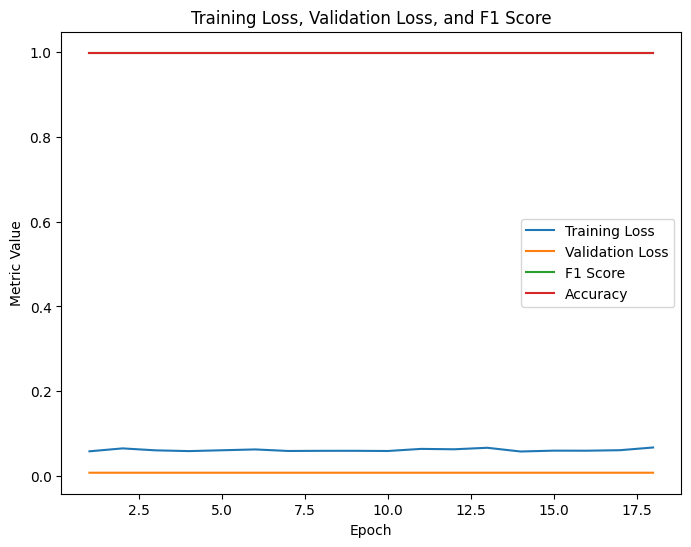

Epoch                 Training Loss         Validation Loss        F1 Score            Accuracy              Precision
--------------------  --------------------  ---------------------  ------------------  ------------------  -----------
1                     0.05824083289107049   0.007691061291460514   0.9987999986559895  0.9988                   0.9988
2                     0.06510543366258306   0.007690076470887878   0.9987999986559895  0.9987999986559895       0.9988
3                     0.06046910943624342   0.007690462510357906   0.9987999986559895  0.9987999986559895       0.9988
4                     0.058707902427902976  0.0076900000416502785  0.9987999986559895  0.9987999986559895       0.9988
5                     0.06069559796403403   0.0076892932790738255  0.9987999986559895  0.9987999986559895       0.9988
6                     0.06264035989306649   0.007688707008934285   0.9987999986559895  0.9987999986559895       0.9988
7                     0.058986099340555403  0.00

In [19]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_vals = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # Initialize metrics lists for this fold
    fold_training_loss_list = []
    fold_validation_loss_list = []
    fold_accuracy_list = []
    fold_precision_list = []
    fold_f1_score_list = []

    try:
        fold_training_loss_list, fold_validation_loss_list, fold_accuracy_list, fold_precision_list, fold_f1_score_list = \
        train_model(trainer, dataloader_train, dataloader_vals, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

    # Append the metrics for this fold to the overall lists
    training_loss_lists.append(fold_training_loss_list)
    validation_loss_lists.append(fold_validation_loss_list)
    accuracy_lists.append(fold_accuracy_list)
    precision_lists.append(fold_precision_list)
    f1_score_lists.append(fold_f1_score_list)

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

model.load_state_dict(
    torch.load(
        "Models/finetuned_gpt_bert_imdb_ft_epoch24.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_test)
accuracy_per_class(predictions, true_vals, label_dict)

Class: 0
Accuracy: 10747/12500 (85.98%)
F1 Score: 0.85

Class: 1
Accuracy: 10472/12500 (83.78%)
F1 Score: 0.85

Total Accuracy: 84.88%
Total F1 Score: 0.85


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.06279415752557972
Validation loss: 1.0013985411219937
F1 Score (weighted): 0.8487416977454272


Epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.0655149109675635
Validation loss: 1.0029638679505324
F1 Score (weighted): 0.8487416977454272
4.33% Training loss increased compared to the previous epoch
0.16% Validation loss increased compared to the previous epoch


Epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.060473434370413255
Validation loss: 1.0041043972897985
F1 Score (weighted): 0.8487416977454272
7.7% Training loss decreased compared to the previous epoch
0.11% Validation loss increased compared to the previous epoch


Epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.06334590734278125
Validation loss: 1.0024007479867512
F1 Score (weighted): 0.8487416977454272
4.75% Training loss increased compared to the previous epoch
0.17% Validation loss decreased compared to the previous epoch


Epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.06646166624299936
Validation loss: 1.0013984671824843
F1 Score (weighted): 0.8487416977454272
4.92% Training loss increased compared to the previous epoch
0.1% Validation loss decreased compared to the previous epoch


Epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.05602177979728202
Validation loss: 1.0019224180131043
F1 Score (weighted): 0.8487416977454272
15.71% Training loss decreased compared to the previous epoch
0.05% Validation loss increased compared to the previous epoch


Epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.05793471818754948
Validation loss: 1.0019832571141174
F1 Score (weighted): 0.8487416977454272
3.41% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.06485053303156912
Validation loss: 1.0013984463928962
F1 Score (weighted): 0.8487416977454272
11.94% Training loss increased compared to the previous epoch
0.06% Validation loss decreased compared to the previous epoch


Epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.06449957722448248
Validation loss: 1.0030255009464282
F1 Score (weighted): 0.8487416977454272
0.54% Training loss decreased compared to the previous epoch
0.16% Validation loss increased compared to the previous epoch


Epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.0639668287980054
Validation loss: 1.002326639675874
F1 Score (weighted): 0.8487416977454272
0.83% Training loss decreased compared to the previous epoch
0.07% Validation loss decreased compared to the previous epoch


Epoch 11:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.06234736416974391
Validation loss: 1.001399582867404
F1 Score (weighted): 0.8487416977454272
2.53% Training loss decreased compared to the previous epoch
0.09% Validation loss decreased compared to the previous epoch


Epoch 12:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.06639079800755678
Validation loss: 1.0022389012616804
F1 Score (weighted): 0.8487416977454272
6.49% Training loss increased compared to the previous epoch
0.08% Validation loss increased compared to the previous epoch


Epoch 13:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.06367685705175642
Validation loss: 1.0032894303003932
F1 Score (weighted): 0.8487416977454272
4.09% Training loss decreased compared to the previous epoch
0.1% Validation loss increased compared to the previous epoch


Epoch 14:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.06527529304102328
Validation loss: 1.0013987661691863
F1 Score (weighted): 0.8487416977454272
2.51% Training loss increased compared to the previous epoch
0.19% Validation loss decreased compared to the previous epoch


Epoch 15:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.06221767594727432
Validation loss: 1.001398364524156
F1 Score (weighted): 0.8487416977454272
4.68% Training loss decreased compared to the previous epoch
0.0% Validation loss decreased compared to the previous epoch


Epoch 16:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.06274995749808196
Validation loss: 1.0033295499253556
F1 Score (weighted): 0.8487416977454272
0.86% Training loss increased compared to the previous epoch
0.19% Validation loss increased compared to the previous epoch


Epoch 17:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.06382721432956631
Validation loss: 1.0021658734842875
F1 Score (weighted): 0.8487416977454272
1.72% Training loss increased compared to the previous epoch
0.12% Validation loss decreased compared to the previous epoch


Epoch 18:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.06288565644688954
Validation loss: 1.0013983845352352
F1 Score (weighted): 0.8487416977454272
1.48% Training loss decreased compared to the previous epoch
0.08% Validation loss decreased compared to the previous epoch


Epoch 19:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.06108624647256213
Validation loss: 1.0014427749921961
F1 Score (weighted): 0.8487416977454272
2.86% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 20:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.0622194380567552
Validation loss: 1.0022727654167332
F1 Score (weighted): 0.8487416977454272
1.86% Training loss increased compared to the previous epoch
0.08% Validation loss increased compared to the previous epoch


Epoch 21:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.06025499702458215
Validation loss: 1.0022957487080348
F1 Score (weighted): 0.8487416977454272
3.16% Training loss decreased compared to the previous epoch
0.0% Validation loss increased compared to the previous epoch


Epoch 22:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.06373673195205563
Validation loss: 1.0024141457199496
F1 Score (weighted): 0.8487416977454272
5.78% Training loss increased compared to the previous epoch
0.01% Validation loss increased compared to the previous epoch


Epoch 23:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.061100403723561285
Validation loss: 1.0019312407582484
F1 Score (weighted): 0.8487416977454272
4.14% Training loss decreased compared to the previous epoch
0.05% Validation loss decreased compared to the previous epoch


Epoch 24:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.06439784634585521
Validation loss: 1.002325313109586
F1 Score (weighted): 0.8487416977454272
5.4% Training loss increased compared to the previous epoch
0.04% Validation loss increased compared to the previous epoch


Epoch 25:   0%|          | 0/704 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.06533225861242252
Validation loss: 1.002504450577276
F1 Score (weighted): 0.8487416977454272
1.45% Training loss increased compared to the previous epoch
0.02% Validation loss increased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 50.54878041346868 minutes
Final Accuracy: 0.84876
Final Precision: 0.8489288815786841


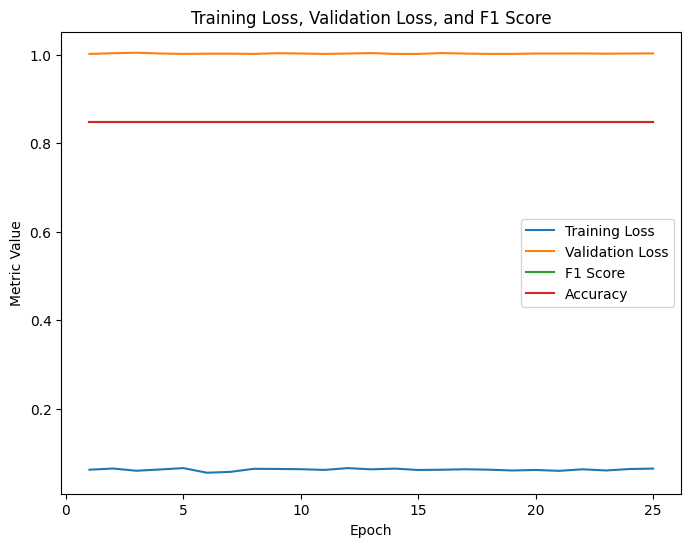

Epoch                 Training Loss         Validation Loss     F1 Score            Accuracy              Precision
--------------------  --------------------  ------------------  ------------------  ------------------  -----------
1                     0.06279415752557972   1.0013985411219937  0.8487416977454272  0.84876                0.848929
2                     0.0655149109675635    1.0029638679505324  0.8487416977454272  0.8487416977454272     0.848742
3                     0.060473434370413255  1.0041043972897985  0.8487416977454272  0.8487416977454272     0.848742
4                     0.06334590734278125   1.0024007479867512  0.8487416977454272  0.8487416977454272     0.848742
5                     0.06646166624299936   1.0013984671824843  0.8487416977454272  0.8487416977454272     0.848742
6                     0.05602177979728202   1.0019224180131043  0.8487416977454272  0.8487416977454272     0.848742
7                     0.05793471818754948   1.0019832571141174  0.848741

([0.06279415752557972,
  0.0655149109675635,
  0.060473434370413255,
  0.06334590734278125,
  0.06646166624299936,
  0.05602177979728202,
  0.05793471818754948,
  0.06485053303156912,
  0.06449957722448248,
  0.0639668287980054,
  0.06234736416974391,
  0.06639079800755678,
  0.06367685705175642,
  0.06527529304102328,
  0.06221767594727432,
  0.06274995749808196,
  0.06382721432956631,
  0.06288565644688954,
  0.06108624647256213,
  0.0622194380567552,
  0.06025499702458215,
  0.06373673195205563,
  0.061100403723561285,
  0.06439784634585521,
  0.06533225861242252],
 [1.0013985411219937,
  1.0029638679505324,
  1.0041043972897985,
  1.0024007479867512,
  1.0013984671824843,
  1.0019224180131043,
  1.0019832571141174,
  1.0013984463928962,
  1.0030255009464282,
  1.002326639675874,
  1.001399582867404,
  1.0022389012616804,
  1.0032894303003932,
  1.0013987661691863,
  1.001398364524156,
  1.0033295499253556,
  1.0021658734842875,
  1.0013983845352352,
  1.0014427749921961,
  1.002272

In [21]:
train_model(trainer, dataloader_train, dataloader_test, epochs, patience)